In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from modules.csvLoader import csvLoader

%load_ext autoreload
%autoreload 2

## Définition de fonctions utiles

In [2]:
def drop_extreme(df, colonne, low_qt, high_qt):
    limite_basse, limite_haute = df[colonne].quantile([low_qt, high_qt])
    # print(limite_basse, ' ', limite_haute)
    return df.query("{low}<=`{colonne}`<={high}".format(low=limite_basse,high=limite_haute,colonne=colonne))

## Lecture des csv

In [3]:
appartement_filtre = csvLoader.load('appartement')

Successfully loaded  appartement.csv


## Observation sur les types de mutation et leur influence sur la valeur de l'appartement

In [4]:
mutations = appartement_filtre['Nature mutation'].drop_duplicates().tolist()
for mutation in mutations:
    df = appartement_filtre[appartement_filtre['Nature mutation']==mutation]
    print('nb ', mutation[:15], ' :\t', len(df), '\tsoit\t', round(len(df)/len(appartement_filtre)*100, 2), ' % des appartements' )

del(mutation, mutations, df)

print()
print('Valeur moyenne par type de bien')
maison_valeur = appartement_filtre[['Nature mutation', 'Valeur fonciere']]
print( maison_valeur.groupby(['Nature mutation']).mean().head() )

del(maison_valeur)

print()
print(len(appartement_filtre))
appartement_filtre = appartement_filtre[appartement_filtre['Nature mutation'] == 'Vente']
print(len(appartement_filtre))

nb  Vente  :	 419899 	soit	 97.97  % des appartements
nb  Vente en l'état  :	 6202 	soit	 1.45  % des appartements
nb  Echange  :	 914 	soit	 0.21  % des appartements
nb  Adjudication  :	 1344 	soit	 0.31  % des appartements
nb  Vente terrain à  :	 244 	soit	 0.06  % des appartements
nb  Expropriation  :	 6 	soit	 0.0  % des appartements

Valeur moyenne par type de bien
                                    Valeur fonciere
Nature mutation                                    
Adjudication                           3.705178e+05
Echange                                1.737324e+05
Expropriation                          1.068143e+07
Vente                                  2.545757e+06
Vente en l'état futur d'achèvement     4.735143e+05

428609
419899


## Suppression des extremes de Nombre de pieces

In [5]:
if len(appartement_filtre) < 410000:
    raise SystemExit("Ce traitement a déjà été effectué !")

print(len(appartement_filtre))
appartement_filtre = drop_extreme(appartement_filtre, 'Nombre pieces principales', 0.05, 0.9)
print(len(appartement_filtre))

nb_pieces = appartement_filtre['Nombre pieces principales'].drop_duplicates().tolist()
nb_pieces.sort()
for piece in nb_pieces:
    df = appartement_filtre[appartement_filtre['Nombre pieces principales']==piece]
    print(int(piece), ' pièces :', len(df), '\tsoit\t', round(len(df)/len(appartement_filtre)*100, 2), ' % des appartements' )

del(nb_pieces, df, piece)

419899
397797
1  pièces : 86494 	soit	 21.74  % des appartements
2  pièces : 124424 	soit	 31.28  % des appartements
3  pièces : 122266 	soit	 30.74  % des appartements
4  pièces : 64613 	soit	 16.24  % des appartements


## Suppression des extremes de 'Valeur fonciere'

In [6]:
if len(appartement_filtre) < 390000:
    raise SystemExit("Ce traitement a déjà été effectué !")

print(len(appartement_filtre))
appartement_filtre = drop_extreme(appartement_filtre, 'Valeur fonciere', 0.05, 0.95)
print(len(appartement_filtre))

397797
359064


## Observation sur les lots

In [ ]:
# appartement_filtre.columns.to_list()
lots = ['1er lot', 'Surface Carrez du 1er lot', '2eme lot', 'Surface Carrez du 2eme lot', '3eme lot', 'Surface Carrez du 3eme lot', '4eme lot',
 'Surface Carrez du 4eme lot', '5eme lot', 'Surface Carrez du 5eme lot']

print(len(appartement_filtre))
for lot in lots:
    print(
        lot,
        ' : ', 
        len(appartement_filtre) - len(appartement_filtre[appartement_filtre[lot].isna()]),
        'appartements soit',
        round(100 - len( appartement_filtre[appartement_filtre[lot].isna()] ) / len(appartement_filtre) * 100, 2),
        '% des appartements.'
    )

del(lot, lots)

## Observation sur les ventes groupées/dupliquées

In [7]:
# appartement_filtre.columns.tolist()
vente_groupe = appartement_filtre.groupby(['Date mutation', 'Valeur fonciere', 'No voie', 'Voie', 'Code postal','Commune'])

## Suppression des extremes de 'Surface terrain'

Subtilité: la plupart des appartements n'ont pas de terrain

31
79729 appartements avec un terrain
279304 appartements sans terrain


<AxesSubplot:>

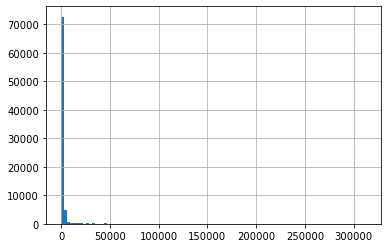

In [8]:
print(len(appartement_filtre[appartement_filtre['Surface terrain'] > 50000]))
print(len(appartement_filtre[appartement_filtre['Surface terrain'] < 50000]), 'appartements avec un terrain')
print(len(appartement_filtre[appartement_filtre['Surface terrain'].isna()]), 'appartements sans terrain')
appartement_filtre['Surface terrain'].hist(bins=100)

In [9]:
if len(appartement_filtre) < 356000:
    raise SystemExit("Ce traitement a déjà été effectué !")

print(len(appartement_filtre))

appartement_sans_terrain = appartement_filtre[appartement_filtre['Surface terrain'].isna()]
appartement_filtre = drop_extreme(appartement_filtre, 'Surface terrain', 0, 0.95)
appartement_filtre = pd.concat([appartement_filtre, appartement_sans_terrain])

print(len(appartement_filtre))

del(appartement_sans_terrain)

359064
355079


## Filtre sur les colonnes inutiles et concatenation des colonnes 'Surface Carrez' et 'Surface reelle'

In [11]:
# maison_filtre = maison_filtre[['Nature mutation', 'Valeur fonciere', 'Code postal', 'Voie', 'Commune', '1er lot', 'Surface Carrez du 1er lot', 'Nombre de lots', 'Type local', 'Surface reelle bati', 'Nombre pieces principales', 'Surface terrain']]

# import math

# def set_surface(row):
#     if math.isnan(row['Surface Carrez du 1er lot']):
#         return row['Surface reelle bati']
#     return row['Surface Carrez du 1er lot']

# maison_filtre['Surface'] = maison_filtre.apply(set_surface, axis=1)
# maison_filtre = maison_filtre.drop(columns=['Surface Carrez du 1er lot', 'Surface reelle bati'])

## Suppression des extremes de Surface

In [12]:
# if len(maison_filtre) < 310000:
#     raise SystemExit("Ce traitement a déjà été effectué !")

# print(len(maison_filtre))
# maison_filtre = drop_extreme(maison_filtre, 'Surface', 0.05, 0.95)
# print(len(maison_filtre))

# Analyses et Graphs

## Relation de la taille du terrain (Y) avec le prix (X)

taille du sample :  35508


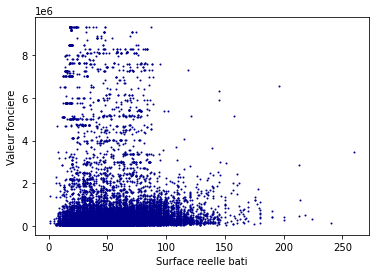

In [13]:
nb_sample = round(0.1*len(appartement_filtre))
print('taille du sample : ', nb_sample)
plot = appartement_filtre.sample(n=nb_sample).plot.scatter(x='Surface reelle bati', y='Valeur fonciere', c='DarkBlue', s=1)
del(nb_sample, plot)

## Recherche de correlation

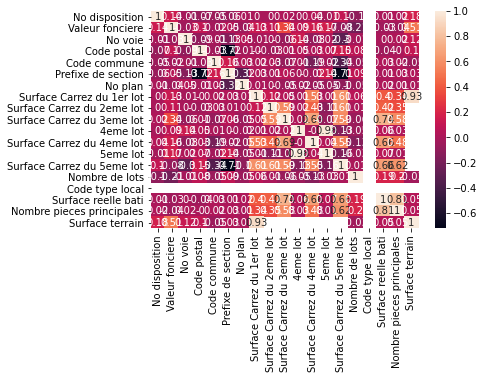

In [14]:
matrice = appartement_filtre.corr().round(2)
sns.heatmap(data=matrice, annot=True)
del(matrice)

In [15]:
# csvLoader.save(maison_filtre, 'maison_filtre', save_index=False)